In [1]:
# -*- coding: utf-8 -*-

from Dataset import Dataset, saveDataset, loadDataset
from CNN_Model import CNN_Model, loadModel, saveModel
from ECOC_Classifier import ECOC_Classifier
from Stage import Stage
from Staged_Network import Staged_Network, saveStagedModel, loadStagedModel

from Utils import *

from keras.models import Sequential, Graph, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.advanced_activations import PReLU

import os
import logging
import numpy as np
import scipy
from skimage.transform import resize

import matplotlib as mpl
#mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 3007)


In [2]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    y, ymax = np.where(rows)[0][[0, -1]]
    x, xmax = np.where(cols)[0][[0, -1]]

    return x, y, xmax-x, ymax-y
    # y, ymax, x, xmax
    #return rmin, rmax, cmin, cmax

Load FoodVsNoFood dataset and test images

In [3]:
# Load dataset for food detection (used for pre-processing the test images)
ds = loadDataset('Datasets/Dataset_FoodVsNoFood.pkl')

In [24]:
# List of test images
path_imgs = 'images'
list_imgs = ['1-eating.jpg', '2-eating.jpg', '3-eating.jpg', '4-eating.jpg', '5-eating.jpg', '6-eating.jpg', '7-eating.jpg',
        '8-eating.jpg', '9-eating.jpg', '10-eating.jpg', '1-noeating.jpg', '2-noeating.jpg', '3-noeating.jpg', '4-noeating.jpg', '5-noeating.jpg']
        
      
# List of UECFood-256 images
path_imgs = '/media/HDD_2TB/DATASETS/UECFOOD256'
# grilled salmon
#list_imgs = ['250/331903.jpg', '250/335194.jpg', '250/331789.jpg', '250/332501.jpg', '250/332318.jpg']    
# rice
list_imgs = ['1/16590.jpg', '1/16670.jpg', '1/16691.jpg', '1/16191.jpg', '1/16012.jpg', '1/14076.jpg']


# Examples Egocentric
#path_imgs = '/media/HDD_2TB/DATASETS'
#list_imgs = ['imagen_original.png']

Load net

In [5]:
new_model_name = 'GoogleNet_FoodVsNoFood_GAP'
reshape_size = [256,256]

# Load model
snet = loadStagedModel('Models/'+new_model_name)

# Adds the output for heatmap generation
snet.getStage(1).model.add_output(name='GAP/conv', input='CAM_conv/relu')
snet.getStage(1).setOptimizer()

# Get weights (position 0 -> no food, positions 1 -> food)
W = snet.getStage(1).model.get_weights()[-2]
b = snet.getStage(1).model.get_weights()[-1] # recover bias although it will not be used

Load test images

In [25]:
list_imgs = [path_imgs+'/'+im for im in list_imgs]

# Pre-processed images
X = ds.loadImages(list_imgs, False, True, False, external=True)

# Raw images
images = np.transpose(ds.loadImages(list_imgs, False, False, False, external=True), (0,2,3,1))
images_ = copy.copy(images)
images[:,:,:,0] = images_[:,:,:,2]
images[:,:,:,2] = images_[:,:,:,0]

In [26]:
# Apply forward pass
X = snet.forwardUntilStage(X,1)['inception_4e']
predictions = np.argmax(snet.getStage(1).predictOnBatch(X, out_name='GAP/softmax'), axis=1)
X = snet.getStage(1).predictOnBatch(X, out_name='GAP/conv')

In [27]:
# Compute heatmaps for each class and each image [n_samples, n_classes, height, width]
maps = np.zeros((X.shape[0], W.shape[1], reshape_size[0], reshape_size[1]))
for s in range(X.shape[0]):
    weighted_activation = np.dot(np.transpose(W), np.reshape(X[s], (W.shape[0], X.shape[2]*X.shape[3])))
    map = np.reshape(weighted_activation, (W.shape[1], X.shape[2], X.shape[3]))
    maps[s] = resize(map, tuple([W.shape[1]]+reshape_size), order=1, preserve_range=True)

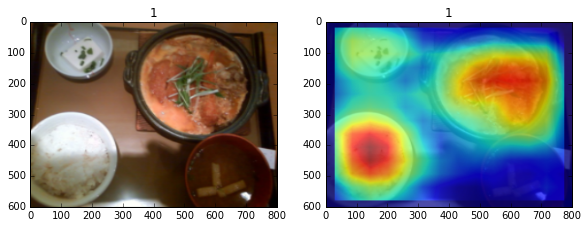

In [33]:
# Plot one of the processed images
id_img = -1
#new_reshape_size = [320, 400]
new_reshape_size = [600, 800]

cmap = plt.get_cmap('jet') # set colormap

f = plt.figure(1)
f.set_size_inches(15, 10)
count = 1
s = id_img
orig = resize(images[s], tuple(reshape_size), order=1, preserve_range=True)
ax = plt.subplot(1, W.shape[1]+1, count)
count += 1
ax.set_title(str(predictions[s]))
plt.imshow(np.array(resize(orig, tuple(new_reshape_size), order=1, preserve_range=True), dtype=np.uint8))
#for c in range(W.shape[1]): # plot each class
for c in [1]:
    norm = (maps[s][c] - np.min(maps[s][c])) / (np.max(maps[s][c]) - np.min(maps[s][c])) # 0-1 normalization
    heat = cmap(norm) # apply colormap
    heat = np.delete(heat, 3, 2) # ???
    heat = np.array(heat[:, :, :3]*255, dtype=np.uint8)
    img = np.array(orig*0.3 + heat*0.7, dtype=np.uint8)
    ax = plt.subplot(1, W.shape[1]+1, count)
    count += 1
    ax.set_title(str(c))
    img = np.array(resize(img, tuple(new_reshape_size), order=1, preserve_range=True), dtype=np.uint8)
    plt.imshow(img)

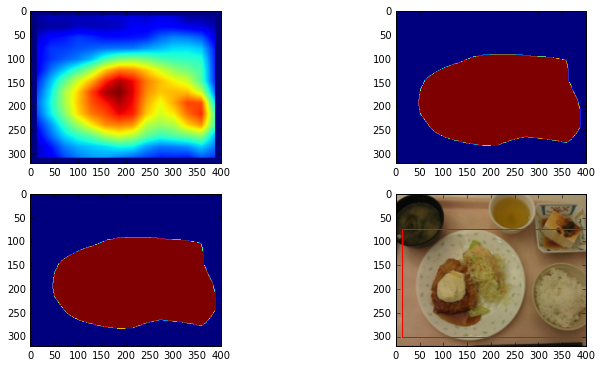

In [23]:
from matplotlib.patches import Rectangle
import scipy
from scipy import ndimage


percentage_heat = 0.8 # threshold of minimum percentage of the max heat (to be considered food)
c = 1 # food
n_bboxes = 9999 # max number of bounding boxes
size_restriction = 0.01 # minimum percentage restriction to consider a bbox
box_expansion = 0.8 # percentage of box expansion


# some tests
percentage_heat = 0.8 # threshold of minimum percentage of the max heat (to be considered food)
size_restriction = 0.00 # minimum percentage restriction to consider a bbox
box_expansion = 1.0 # percentage of box expansion


# best cross-validation
percentage_heat = 0.4 # threshold of minimum percentage of the max heat (to be considered food)
size_restriction = 0.00 # minimum percentage restriction to consider a bbox
box_expansion = 0.2 # percentage of box expansion



# Get last foodness heatmap
norm = (maps[s][c] - np.min(maps[s][c])) / (np.max(maps[s][c]) - np.min(maps[s][c])) # 0-1 normalization
heat = cmap(norm) # apply colormap
heat = np.delete(heat, 3, 2) # ???
heat = np.array(heat[:, :, :3]*255, dtype=np.uint8)

# Detect regions above a certain percentage of the max heat
bb_thres = np.max(maps[s][c])*percentage_heat

# Compute binary selected region
binary_heat = maps[s][c]
binary_heat = np.where(binary_heat>bb_thres, 255, 0)


# Get biggest connected component
min_size = orig.shape[0] * orig.shape[1] * size_restriction
labeled, nr_objects = ndimage.label(binary_heat) # get connected components
[objects, counts] = np.unique(labeled, return_counts=True) # count occurrences
biggest_components = np.argsort(counts[1:])[::-1]
selected_components = [1 if counts[i+1] >= min_size else 0 for i in biggest_components] # check minimum size restriction
biggest_components = biggest_components[:min([np.sum(selected_components), n_bboxes])] # get top n_bboxes


# Show comparison before and after binarization
f = plt.figure(1)
f.set_size_inches(12, 3*(np.sum(selected_components)+1))
plt.subplot(np.sum(selected_components)+1, 2, 1)
plt.imshow(np.array(resize(heat, tuple(new_reshape_size), order=1, preserve_range=True), dtype=np.uint8))
plt.subplot(np.sum(selected_components)+1, 2, 2)
plt.imshow(np.array(resize(binary_heat, tuple(new_reshape_size), order=1, preserve_range=True), dtype=np.uint8))


# Plot each component
count = 3
for selected, comp in zip(selected_components, biggest_components):
    if(selected):
        max_heat = np.where(labeled == comp+1, 255, 0) # get the biggest
        plt.subplot(np.sum(selected_components)+1, 2, count)
        count +=1
        plt.imshow(np.array(resize(max_heat, tuple(new_reshape_size), order=1, preserve_range=True), dtype=np.uint8))


        # Draw bounding box on original image
        box = bbox(max_heat)
        box = list(box)
        
        # expand box before final detection
        x_exp = box[2] * box_expansion
        y_exp = box[3] * box_expansion
        box[0] = max([0, box[0]-x_exp/2])
        box[1] = max([0, box[1]-y_exp/2])
        box[2] += x_exp
        box[3] += y_exp
        
        bbox_reshape = np.array(new_reshape_size, dtype=np.float)/np.array(orig.shape[0:2], dtype=np.float)
        box = np.array(box) * [bbox_reshape[1], bbox_reshape[0], bbox_reshape[1], bbox_reshape[0]] # resize box w.r.t. new_reshape_size
        
        ax = plt.subplot(np.sum(selected_components)+1, 2, count)
        count +=1
        orig_plot = np.array(resize(orig, tuple(new_reshape_size), order=1, preserve_range=True), dtype=np.uint8)
        plt.imshow(orig_plot)
        ax.add_patch(Rectangle((box[0], box[1]), box[2], box[3], facecolor="none", edgecolor='red'))